## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import rasterio as rio
import sklearn
import scipy
import seaborn as sns

In [2]:
import matplotlib
matplotlib.rcParams["image.origin"] = 'upper'

In [3]:
import tqdm
#from tqdm import tqdm
from tqdm.notebook import tqdm # for notebooks
tqdm.pandas()

In [4]:
import pickle
import gc
collectAll = lambda : gc.collect(0) + gc.collect(1) + gc.collect(2)

In [5]:
from collections import namedtuple
import itertools
from itertools import product

In [6]:
from skimage.feature import graycomatrix
from skimage.feature import graycoprops
from math import pi

In [7]:
import PIL as pil
from PIL import Image, ImageDraw

In [8]:
import math

In [9]:
import sys
import os

In [10]:
import functools

In [11]:
import torch
import torchvision

In [12]:
from einops import *

In [13]:
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [14]:
import networkx as nx

In [15]:
from pathlib import Path

In [16]:
import umap
#Note: VERY HACKY: Manually fixed broken deps install.
import umap.plot
from umap import UMAP

E:\miniconda3\envs\up-to-date-env\Lib\site-packages\umap\plot.py:203: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(nopython=False)


In [17]:
import glasbey

## Load our captures

In [18]:
df = pd.read_pickle('df_unified.pickle')

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       80 non-null     object
 1   ymin       80 non-null     int64 
 2   ymax       80 non-null     int64 
 3   xmin       80 non-null     int64 
 4   xmax       80 non-null     int64 
 5   src        80 non-null     object
 6   tree_name  80 non-null     object
 7   crop       80 non-null     object
dtypes: int64(4), object(4)
memory usage: 5.1+ KB


In [20]:
bands = ['wr', 'wg', 'wb', 'r', 'g', 'b', 'nir', 'red_edge', 'ndvi']

bands_readable = {
    'wr': 'Wideband Red',
    'wg': 'Wideband Blue',
    'wb': 'Wideband Green',
    'r': 'Narrowband Red',
    'g': 'Narrowband Blue',
    'b': 'Narrowband Green',
    'nir': 'Near-Infrared',
    'red_edge': 'Red-Edge',
    'ndvi': 'NDVI'
}

## Produce the Facenet embeddings

### Apply the GLCM mean filter

In [21]:
from glcm_cupy import GLCM, Direction, Features

In [22]:
df_facenet = df.copy()

In [23]:
tuple(Direction)

(<Direction.EAST: 0>,
 <Direction.SOUTH_EAST: 1>,
 <Direction.SOUTH: 2>,
 <Direction.SOUTH_WEST: 3>)

In [24]:
list(Features)

[<Features.HOMOGENEITY: 0>,
 <Features.CONTRAST: 1>,
 <Features.ASM: 2>,
 <Features.MEAN: 3>,
 <Features.VARIANCE: 4>,
 <Features.CORRELATION: 5>,
 <Features.DISSIMILARITY: 6>]

In [25]:
def parallel_run(crop):
    from glcm_cupy import GLCM, Direction, Features
    g = GLCM(
        directions=tuple(Direction),
        features=(Features.MEAN,),
        bin_from=2**14, bin_to=128,
        normalized_features=True,
        verbose=False,
        step_size=7,
        radius=3
    )
    return g.run(crop)

In [26]:
df_facenet['crop_glcm_filter'] = df_facenet['crop'].parallel_apply(parallel_run)

In [27]:
df_facenet.to_pickle('df_facenet.pickle')

### Ready our Facenet inputs

In [28]:
selected = list(itertools.product(('none', 'mean'),
                                  ('re', 'b', 'nir', 'r', 'g')))
selected = [(i[1], i[0]) for i in selected]
selected

[('re', 'none'),
 ('b', 'none'),
 ('nir', 'none'),
 ('r', 'none'),
 ('g', 'none'),
 ('re', 'mean'),
 ('b', 'mean'),
 ('nir', 'mean'),
 ('r', 'mean'),
 ('g', 'mean')]

In [29]:
bands

['wr', 'wg', 'wb', 'r', 'g', 'b', 'nir', 'red_edge', 'ndvi']

In [30]:
def get_facenet_inputs(crop, crop_glcm_filter):
    feature_selector = [bands.index(band) for band in ['red_edge', 'b', 'nir', 'r', 'g']]
    a = crop[:,:,feature_selector] / 127
    b = crop_glcm_filter[:,:,feature_selector, Features.MEAN]
    return np.concatenate((a[:b.shape[0],:b.shape[1]], b), axis=2)

In [31]:
df_facenet['crop_none_and_mean_filter'] = df_facenet.progress_apply(
    lambda x: get_facenet_inputs(x['crop'], x['crop_glcm_filter']),
    axis=1)

  0%|          | 0/80 [00:00<?, ?it/s]

### Sanity test for our Facenet inputs

In [32]:
bands = ['red_edge', 'b', 'nir', 'r', 'g']

In [33]:
crop = df_facenet['crop_none_and_mean_filter'].iloc[0]

Text(0.5, 1.0, 'filter: glcm mean')

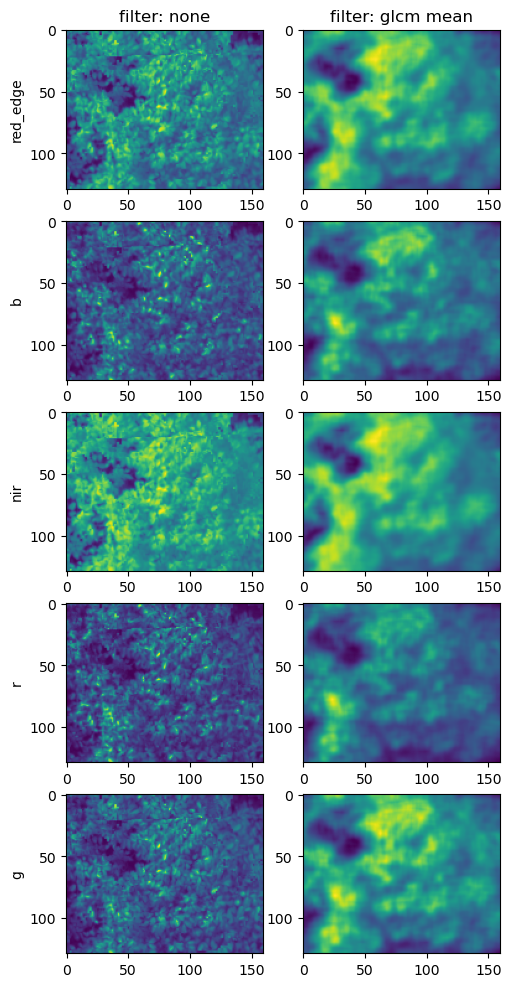

In [34]:
fig, ax = plt.subplots(nrows := len(bands), ncols := 2,
                       figsize=(5.6*ncols/2, 4.8*nrows/2))
for band, row in zip(bands, ax):
    filter_none = crop[:,:,bands.index(band)]
    filter_mean = crop[:,:,len(bands)+bands.index(band)]
    row[0].imshow(filter_none)
    row[1].imshow(filter_mean)
    row[0].set_ylabel(band)
ax[0][0].set_title('filter: none')
ax[0][1].set_title('filter: glcm mean')

### A different sanity test for our facenet inputs

In [35]:
df_facenet['crop_none_and_mean_filter'].apply(lambda x: x.shape[-1]).unique()

array([10], dtype=int64)

## Perform the random cropping and resizing

In [36]:
import tensorflow as tf

In [37]:
transform = torchvision.transforms.RandomResizedCrop(
    size=(250,250),
    scale=((64/250)**2,1),
    ratio=(1/2, 2),
    interpolation=torchvision.transforms.InterpolationMode.BICUBIC,
    antialias=True
)

In [38]:
def rand_crop_stretch(pre_trans, n):
    return\
        [rearrange(
            transform(torch.Tensor(rearrange(pre_trans, 'h w c -> c h w'))).numpy(),
            'c h w -> h w c')
         for i in range(n)]

In [39]:
df_facenet['crop_augmented'] = df_facenet['crop_none_and_mean_filter'].progress_apply(lambda x: rand_crop_stretch(x, 20))

  0%|          | 0/80 [00:00<?, ?it/s]

In [40]:
df_facenet = df_facenet.explode(['crop_augmented'])

## Sanity check again

In [41]:
crop = df_facenet['crop_augmented'].iloc[0]

Text(0.5, 1.0, 'filter: glcm mean')

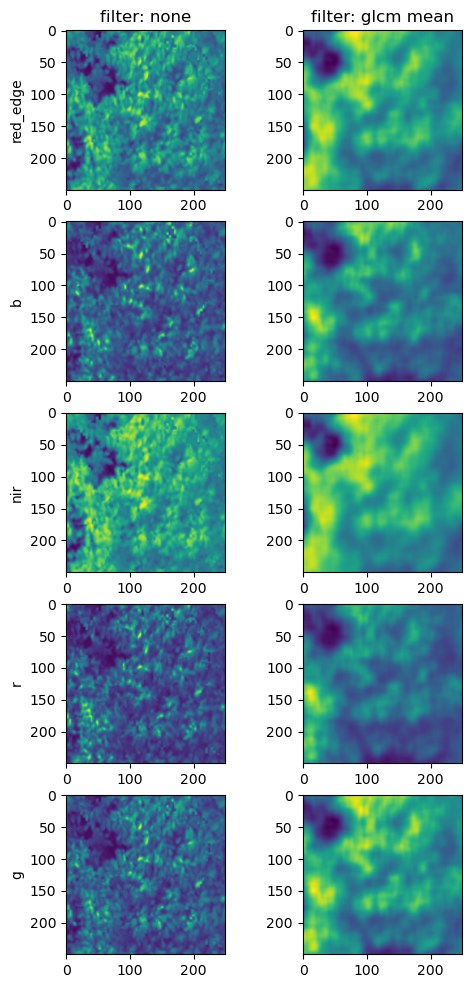

In [42]:
fig, ax = plt.subplots(nrows := len(bands), ncols := 2,
                       figsize=(5.6*ncols/2, 4.8*nrows/2))
for band, row in zip(bands, ax):
    filter_none = crop[:,:,bands.index(band)]
    filter_mean = crop[:,:,len(bands)+bands.index(band)]
    row[0].imshow(filter_none)
    row[1].imshow(filter_mean)
    row[0].set_ylabel(band)
ax[0][0].set_title('filter: none')
ax[0][1].set_title('filter: glcm mean')

In [43]:
df_facenet['crop_augmented'].apply(lambda x: x.shape).unique()

array([(250, 250, 10)], dtype=object)

## Run the facenet model

In [44]:
import tensorflow as tf
import model
from model import face_model
face_model = model.face_model
class Params():
    def __init__(self):
        self.image_size = 250
        self.embedding_size=128
fm = face_model(Params())
checkpoint = tf.train.Checkpoint(fm)
checkpoint.restore('./ckpt/ckpt-11')

def embed_tf(x):
    return tf.math.l2_normalize(fm(x.reshape((-1, *x.shape))), axis=1, epsilon=1e-10).numpy()

In [45]:
df_facenet['embedding'] = df_facenet['crop_augmented'].progress_apply(embed_tf)

  0%|          | 0/1600 [00:00<?, ?it/s]

In [46]:
df_facenet.to_pickle('df_facenet.pickle')